In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import pandas as pd
import yfinance as yf
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.optimize as sco

In [4]:
tickers = ['AAPL', 'BAC', 'INTC', 'GME', 'BA', 'BABA', 'UA', 'KO', 'NVDA', 'META']

In [5]:
data = yf.download(tickers, start = '2018-01-01', end = '2021-01-01', group_by = 'ticker', threads = True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [6]:
data.stack()

C:\Users\dfdop\AppData\Local\Temp\ipykernel_20896\2489631911.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data.stack()


Ticker                      UA          META          BABA          INTC  \
Date       Price                                                           
2018-01-02 Close        13.970  1.805690e+02  1.773594e+02  3.933038e+01   
           High         14.010  1.807282e+02  1.777940e+02  3.937236e+01   
           Low          13.230  1.767171e+02  1.696817e+02  3.879311e+01   
           Open         13.450  1.768465e+02  1.703567e+02  3.893582e+01   
           Volume  6264809.000  1.815190e+07  2.991690e+07  2.337080e+07   
...                        ...           ...           ...           ...   
2020-12-31 Close        14.880  2.718786e+02  2.247582e+02  4.503854e+01   
           High         15.113  2.757902e+02  2.307362e+02  4.537303e+01   
           Low          14.810  2.685443e+02  2.231135e+02  4.404411e+01   
           Open         15.010  2.707241e+02  2.293262e+02  4.407123e+01   
           Volume  1981656.000  1.290040e+07  2.345180e+07  2.857680e+07   

Ticker                      GME          NVDA          AAPL           BAC  \
Date       Price                                                            
2018-01-02 Close   3.988464e+00  4.929429e+00  4.047984e+01  2.519165e+01   
           High    3.995017e+00  4.933138e+00  4.048924e+01  2.519165e+01   
           Low     3.883620e+00  4.809500e+00  3.977487e+01  2.494732e+01   
           Open    3.922936e+00  4.841151e+00  3.998636e+01  2.506527e+01   
           Volume  1.133080e+07  3.556160e+08  1.022236e+08  5.712160e+07   
...                         ...           ...           ...           ...   
2020-12-31 Close   4.710000e+00  1.302075e+01  1.296091e+02  2.731158e+01   
           High    4.950000e+00  1.311650e+01  1.316115e+02  2.738367e+01   
           Low     4.700000e+00  1.288112e+01  1.286616e+02  2.694214e+01   
           Open    4.812500e+00  1.310204e+01  1.309668e+02  2.704126e+01   
           Volume  2.769080e+07  1.924240e+08  9.911660e+07  2.871600e+07   

Ticker                       KO            BA  
Date       Price                               
2018-01-02 Close   3.627222e+01  2.828864e+02  
           High    3.659081e+01  2.830294e+02  
           Low     3.624832e+01  2.815141e+02  
           Open    3.656692e+01  2.818477e+02  
           Volume  1.087220e+07  2.978900e+06  
...                         ...           ...  
2020-12-31 Close   4.821767e+01  2.140600e+02  
           High    4.829680e+01  2.169000e+02  
           Low     4.771650e+01  2.127000e+02  
           Open    4.787477e+01  2.162400e+02  
           Volume  8.495000e+06  1.048760e+07  

[3780 rows x 10 columns]

<Axes: xlabel='Date'>

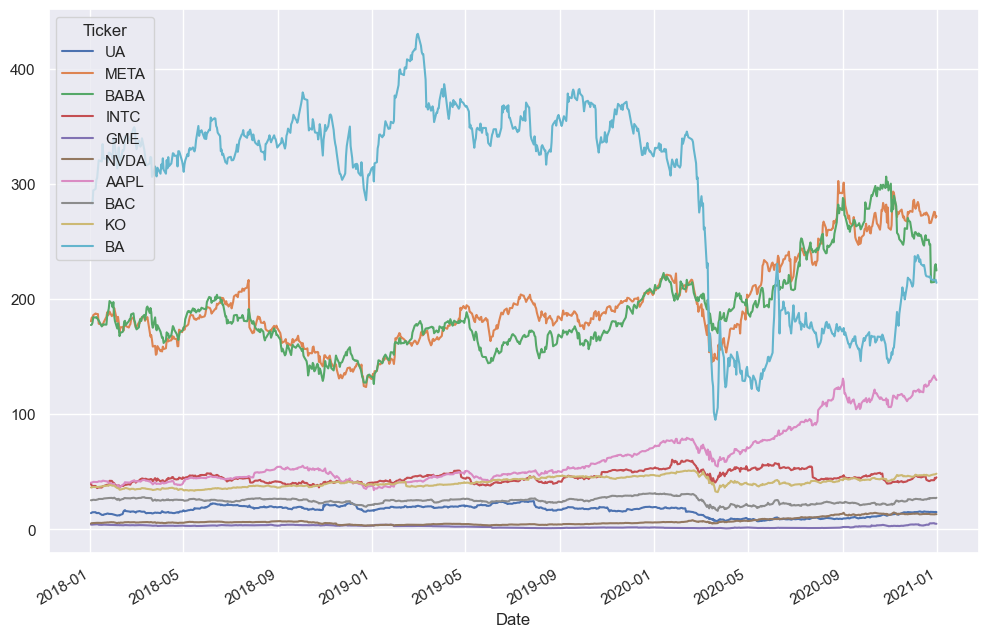

In [7]:
close_prices = data.xs('Close', axis = 1, level = 1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

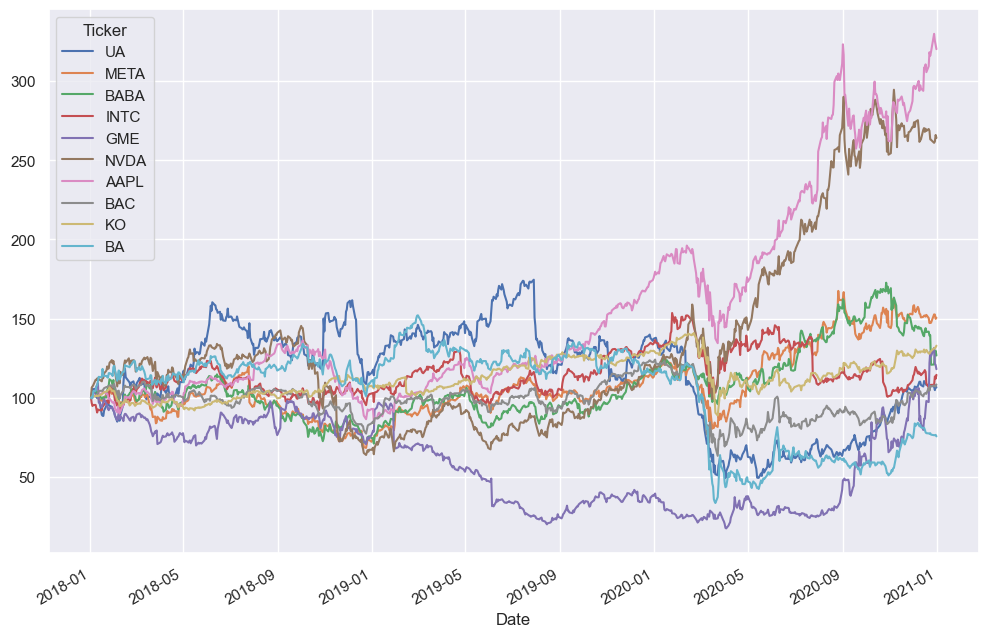

In [8]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize = (12, 8))

In [9]:
simple_retunrs = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

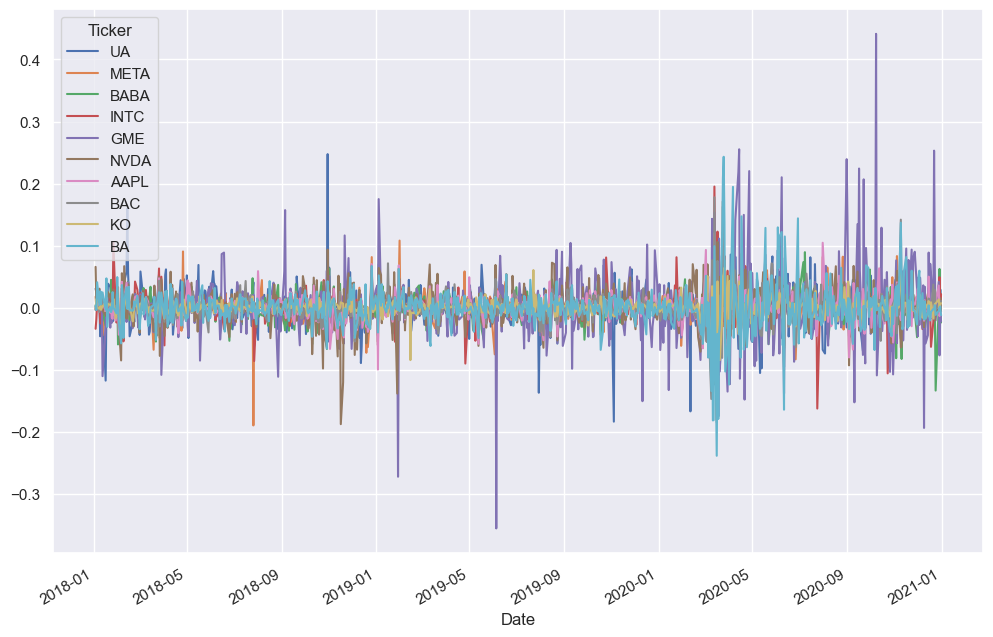

In [10]:
simple_retunrs.plot(kind = 'line', figsize = (12, 8))

In [11]:
daily_returns = simple_retunrs.mean()
daily_risk = simple_retunrs.std()

In [12]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 - 1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [13]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

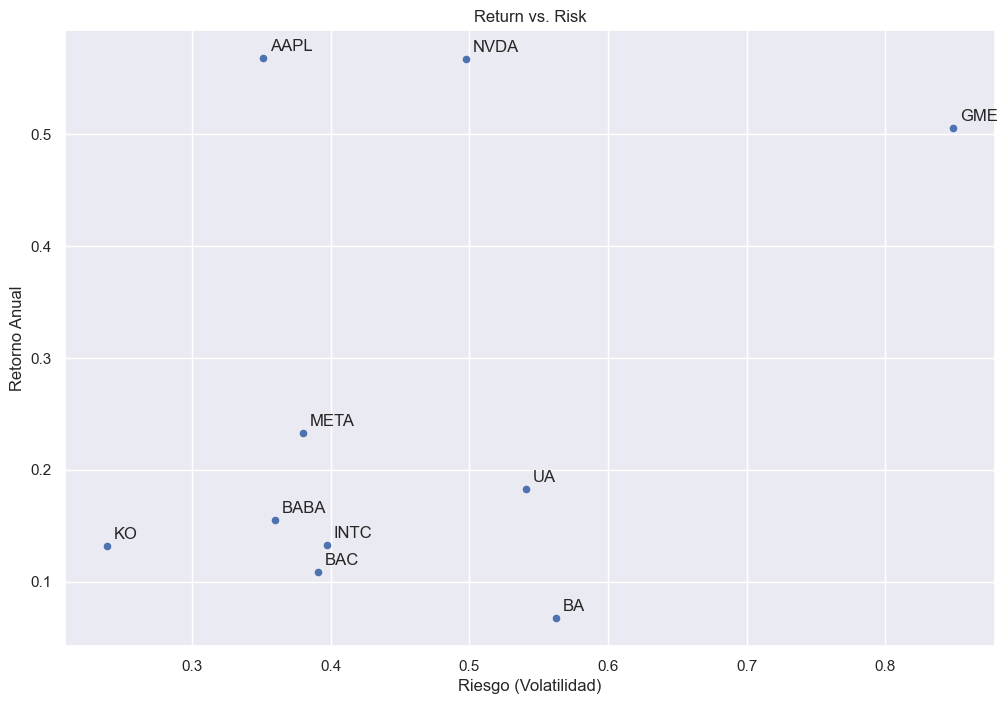

In [14]:
ax = return_risk.plot(
    kind = 'scatter',
    x = 'yearly_risk',
    y = 'yearly_returns',
    figsize = (12, 8),
    title = 'Return vs. Risk'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext = (5, 5),
        textcoords = 'offset points'
    )
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

Calculando la frontera eficiente por medio de simulacion

In [15]:
cov_matrix = simple_retunrs.cov().to_numpy()*252
exp_returns = yearly_returns.to_numpy()

n_portfolios = 250000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, exp_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = port_std*100
    results[1, i] = port_return*100
    # Compute Sharp Ratio with a free risk iquals zero
    results[2, i] = (port_return - 0.0178) / port_std


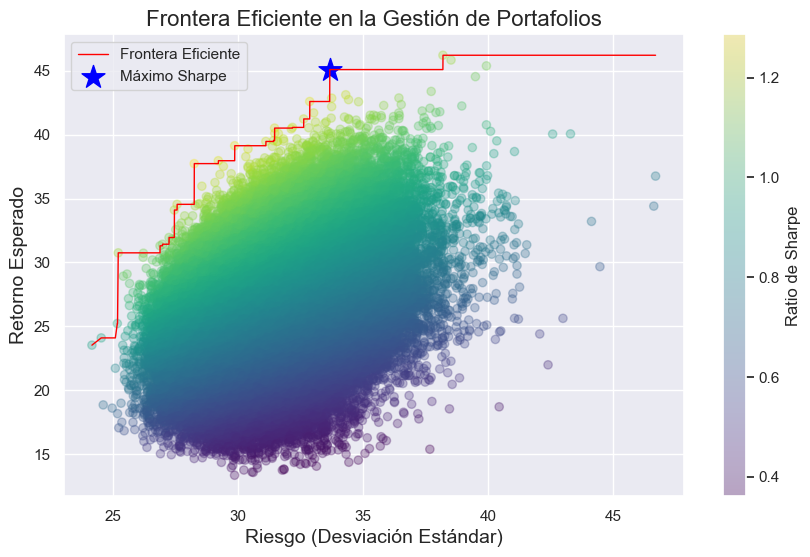

In [16]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_std = results[0, max_sharpe_idx]
max_sharpe_ret = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Ordenar portafolios por riesgo para calcular la frontera eficiente
sorted_indices = np.argsort(results[0])
sorted_risks = results[0, sorted_indices]
sorted_returns = results[1, sorted_indices]

# Calcular el máximo acumulado de retornos, que aproxima la frontera eficiente
efficient_returns = np.maximum.accumulate(sorted_returns)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sc = plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.3)
plt.plot(sorted_risks, efficient_returns, color='red', linewidth=1, label='Frontera Eficiente')
plt.scatter(max_sharpe_std, max_sharpe_ret, color='blue', marker='*', s=300, label='Máximo Sharpe')
plt.title('Frontera Eficiente en la Gestión de Portafolios', fontsize=16)
plt.xlabel('Riesgo (Desviación Estándar)', fontsize=14)
plt.ylabel('Retorno Esperado', fontsize=14)
plt.colorbar(sc, label='Ratio de Sharpe')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    mean_returns = mean_returns.apply(lambda x : (1 + x)**252 - 1)
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

In [18]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [33]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(12, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [34]:
returns = simple_retunrs
mean_returns = returns.mean()
cov_matrix = returns.cov()*252
num_portfolios = 250000
risk_free_rate = 0.0178

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.46
Annualised Volatility: 0.35


Ticker        UA  META  BABA  INTC    GME   NVDA   AAPL    BAC    KO    BA
allocation  0.88  1.33  1.23   1.7  19.13  22.65  36.29  11.79  2.81  2.19
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.24


Ticker        UA   META  BABA  INTC   GME  NVDA  AAPL   BAC     KO    BA
allocation  5.52  19.47  6.01  0.68  6.83  0.67  9.02  1.01  47.33  3.46


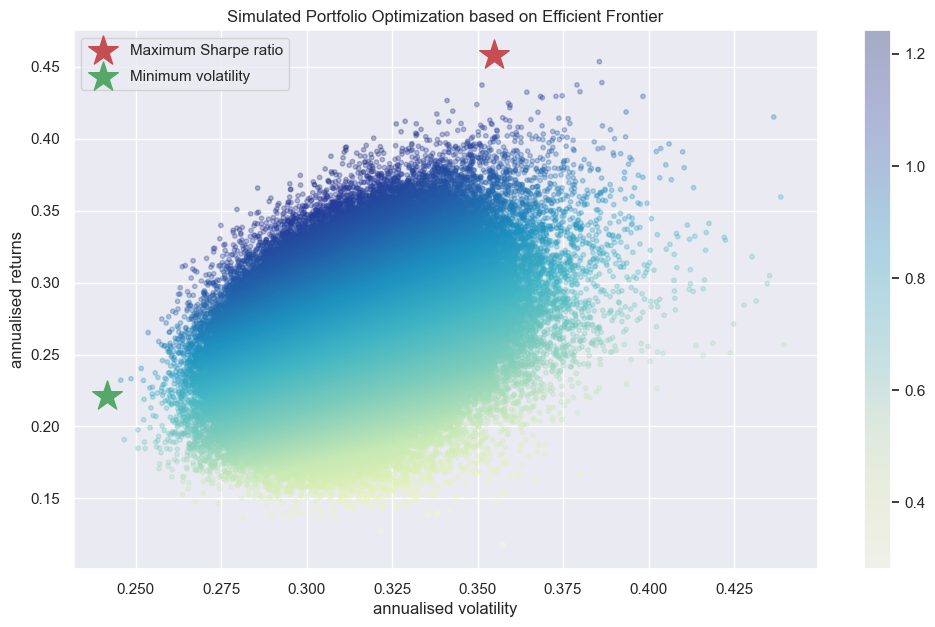

In [35]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [ ]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [23]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [24]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [36]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.6, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.57
Annualised Volatility: 0.35


Ticker       UA  META  BABA  INTC   GME  NVDA   AAPL  BAC   KO   BA
allocation  0.0   0.0   0.0   0.0  4.15  4.72  91.13  0.0  0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.22


Ticker       UA  META   BABA  INTC   GME  NVDA  AAPL  BAC     KO   BA
allocation  0.0  9.18  20.37   0.0  0.54   0.0   0.0  0.0  69.91  0.0


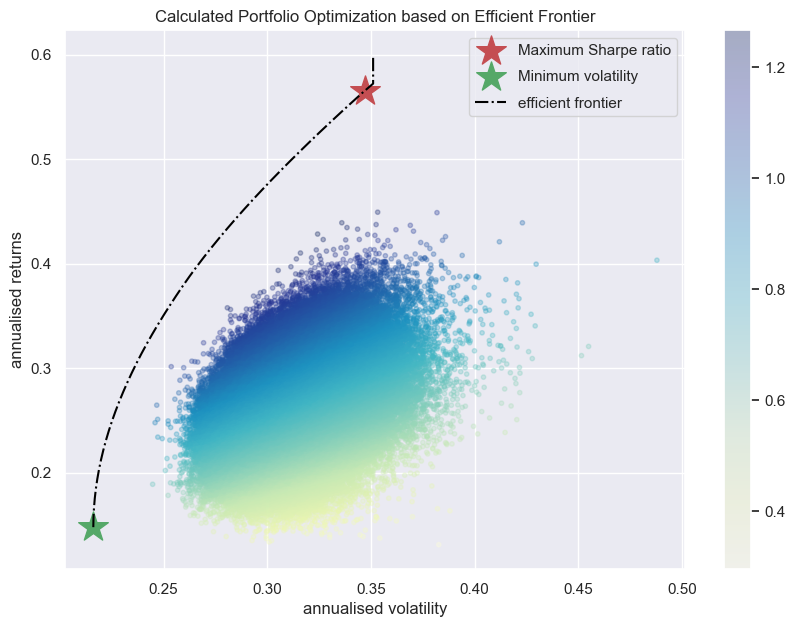

In [37]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [38]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(mean_returns.index):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.6, 500)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_20896\244077497.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
C:\Users\dfdop\AppData\Local\Temp\ipykernel_20896\244077497.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.57
Annualised Volatility: 0.35


Ticker       UA  META  BABA  INTC   GME  NVDA   AAPL  BAC   KO   BA
allocation  0.0   0.0   0.0   0.0  4.15  4.72  91.13  0.0  0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.22


Ticker       UA  META   BABA  INTC   GME  NVDA  AAPL  BAC     KO   BA
allocation  0.0  9.18  20.37   0.0  0.54   0.0   0.0  0.0  69.91  0.0
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

UA : annuaised return 0.17 , annualised volatility: 0.54
META : annuaised return 0.21 , annualised volatility: 0.38
BABA : annuaised return 0.14 , annualised volatility: 0.36
INTC : annuaised return 0.12 , annualised volatility: 0.4
GME : annuaised

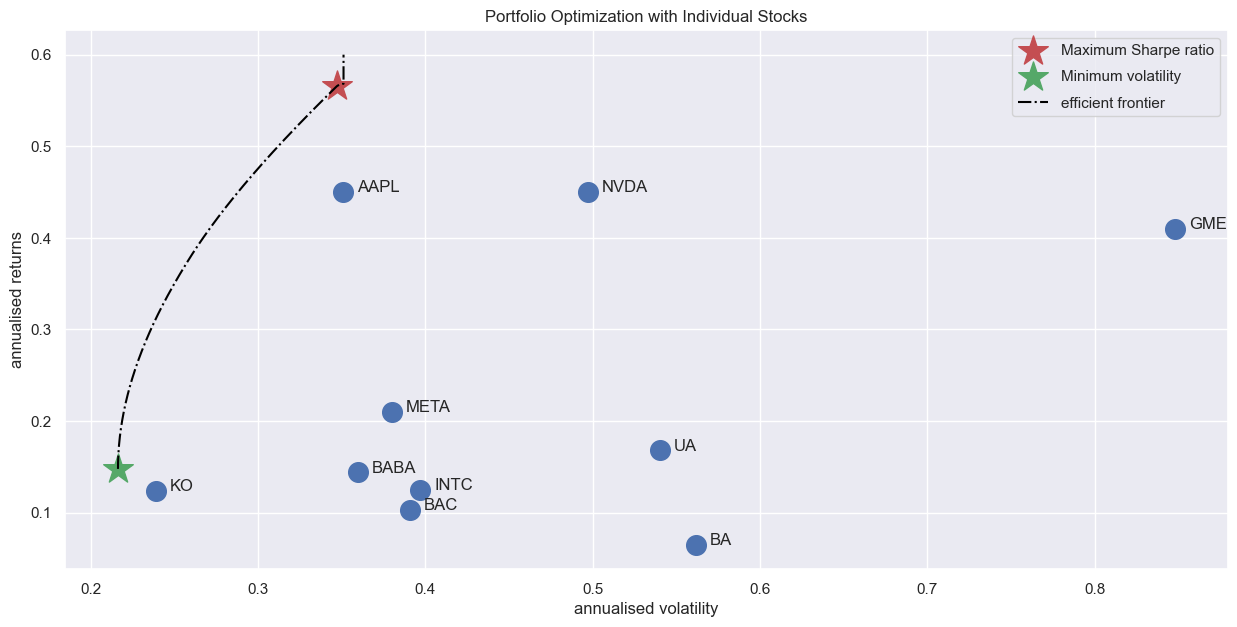

In [39]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

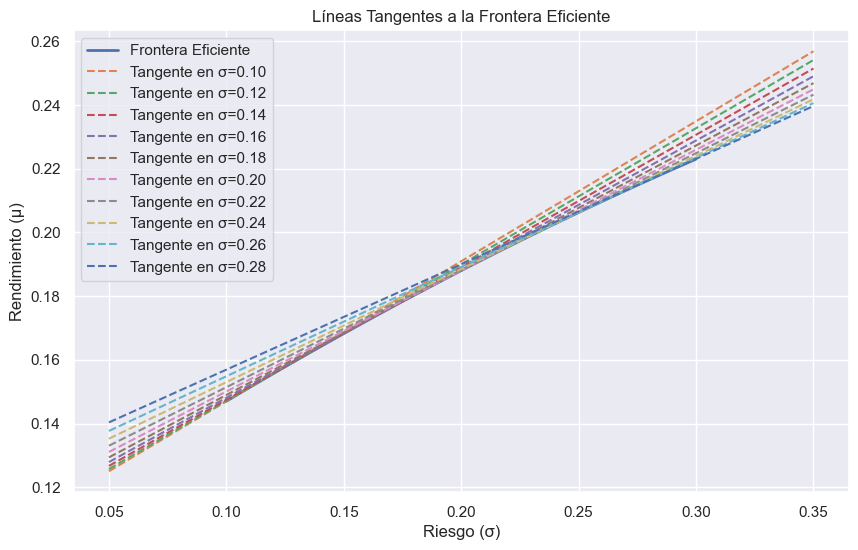

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo: Supongamos que la frontera eficiente se aproxima por:
# mu(σ) = 0.1 + 0.5*σ - 0.3*σ^2
# Donde σ representa el riesgo (desviación estándar) y μ el rendimiento esperado.

# Generamos un conjunto de valores para σ
sigma = np.linspace(0.1, 0.3, 100)
mu = 0.1 + 0.5 * sigma - 0.3 * sigma**2

# Calculamos la derivada numérica de μ respecto a σ usando np.gradient
dmu_dsigma = np.gradient(mu, sigma)

# Preparamos un rango para dibujar las líneas tangentes
x_vals = np.linspace(sigma.min() - 0.05, sigma.max() + 0.05, 200)

plt.figure(figsize=(10, 6))
plt.plot(sigma, mu, label='Frontera Eficiente', linewidth=2)

# Dibujamos la línea tangente en varios puntos de la frontera (por ejemplo, cada 10 puntos)
for i in range(0, len(sigma), 10):
    m = dmu_dsigma[i]         # Pendiente en el punto i
    x0 = sigma[i]
    y0 = mu[i]
    tangent_line = y0 + m * (x_vals - x0)
    plt.plot(x_vals, tangent_line, '--', label=f'Tangente en σ={x0:.2f}')

plt.xlabel('Riesgo (σ)')
plt.ylabel('Rendimiento (μ)')
plt.title('Líneas Tangentes a la Frontera Eficiente')
plt.legend()
plt.grid(True)
plt.show()
